## **Author**:
  - **ebrahim saad**


  ## contents
  1. **reading data and overview**
  2. **EDA and column-wise analysis**
  3. **data preprocessing**
  4. **model training**
  5. **model evaluation**
  6. **model enhancing and feature engineering**
  7. **conclusion**

# reading data and overview




## reading data

**importing libraries**

In [16]:
# Data handling and numerical operations
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and data transformation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.utils import resample # For resampling data

# Model selection and evaluation utilities
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    adjusted_rand_score,
    make_scorer
)

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    StackingClassifier
)
from xgboost import XGBClassifier as xgboost # XGBoost
from sklearn.cluster import KMeans, DBSCAN # Clustering algorithms

# Hyperparameter Optimization
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Utilities
import joblib # For saving and loading models
from sklearn.exceptions import NotFittedError # For handling model fitting errors
from scipy import stats # For statistical functions


import warnings
warnings.filterwarnings("ignore")


**reading data**

In [17]:
df = pd.read_csv('Water_Data.csv')

## data over view

In [18]:
shape = df.shape

print(f"The dataset has {shape[0]} rows and {shape[1]} columns.")

The dataset has 3318 rows and 10 columns.


In [19]:
df.head().style.background_gradient(cmap='Blues')

In [20]:
df.describe().style.background_gradient(cmap='Blues')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3318 entries, 0 to 3317
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2821 non-null   float64
 1   Hardness         3318 non-null   float64
 2   Solids           3317 non-null   float64
 3   Chloramines      3318 non-null   float64
 4   Sulfate          2524 non-null   float64
 5   Conductivity     3318 non-null   float64
 6   Organic_carbon   3318 non-null   float64
 7   Trihalomethanes  3152 non-null   float64
 8   Turbidity        3318 non-null   float64
 9   Potability       3318 non-null   object 
dtypes: float64(9), object(1)
memory usage: 259.3+ KB


In [22]:
null_percentages = df.isnull().sum() / len(df) * 100

for column, percentage in null_percentages.items():
  if (percentage != 0):
    print(f"{column} has {percentage:.2f}% null values")

ph has 14.98% null values
Solids has 0.03% null values
Sulfate has 23.93% null values
Trihalomethanes has 5.00% null values


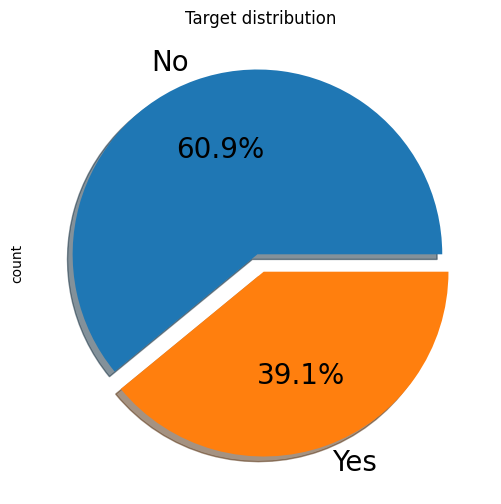

In [23]:
plt.figure(figsize=(6,6))
df['Potability'].value_counts().plot.pie(explode=[0.05,0.05],
                    autopct='%1.1f%%', shadow=True,
                    textprops={'fontsize':20}).set_title("Target distribution");

over view conclusion

- target variable is imbalanced, with about two third of it zeros (resampling would be useful)
- ph is 15% null
- Sulfate is 24% null
- Trihalomethanes is 5% null
- some ph values isn't resonable, like 0, that indicates something wrong with these values
- not ph only, solids and hardness has non-reasonable values, we will explore this more in further analysis

# EDA and column-wise analysis

## Exploratory data analysis (EDA)

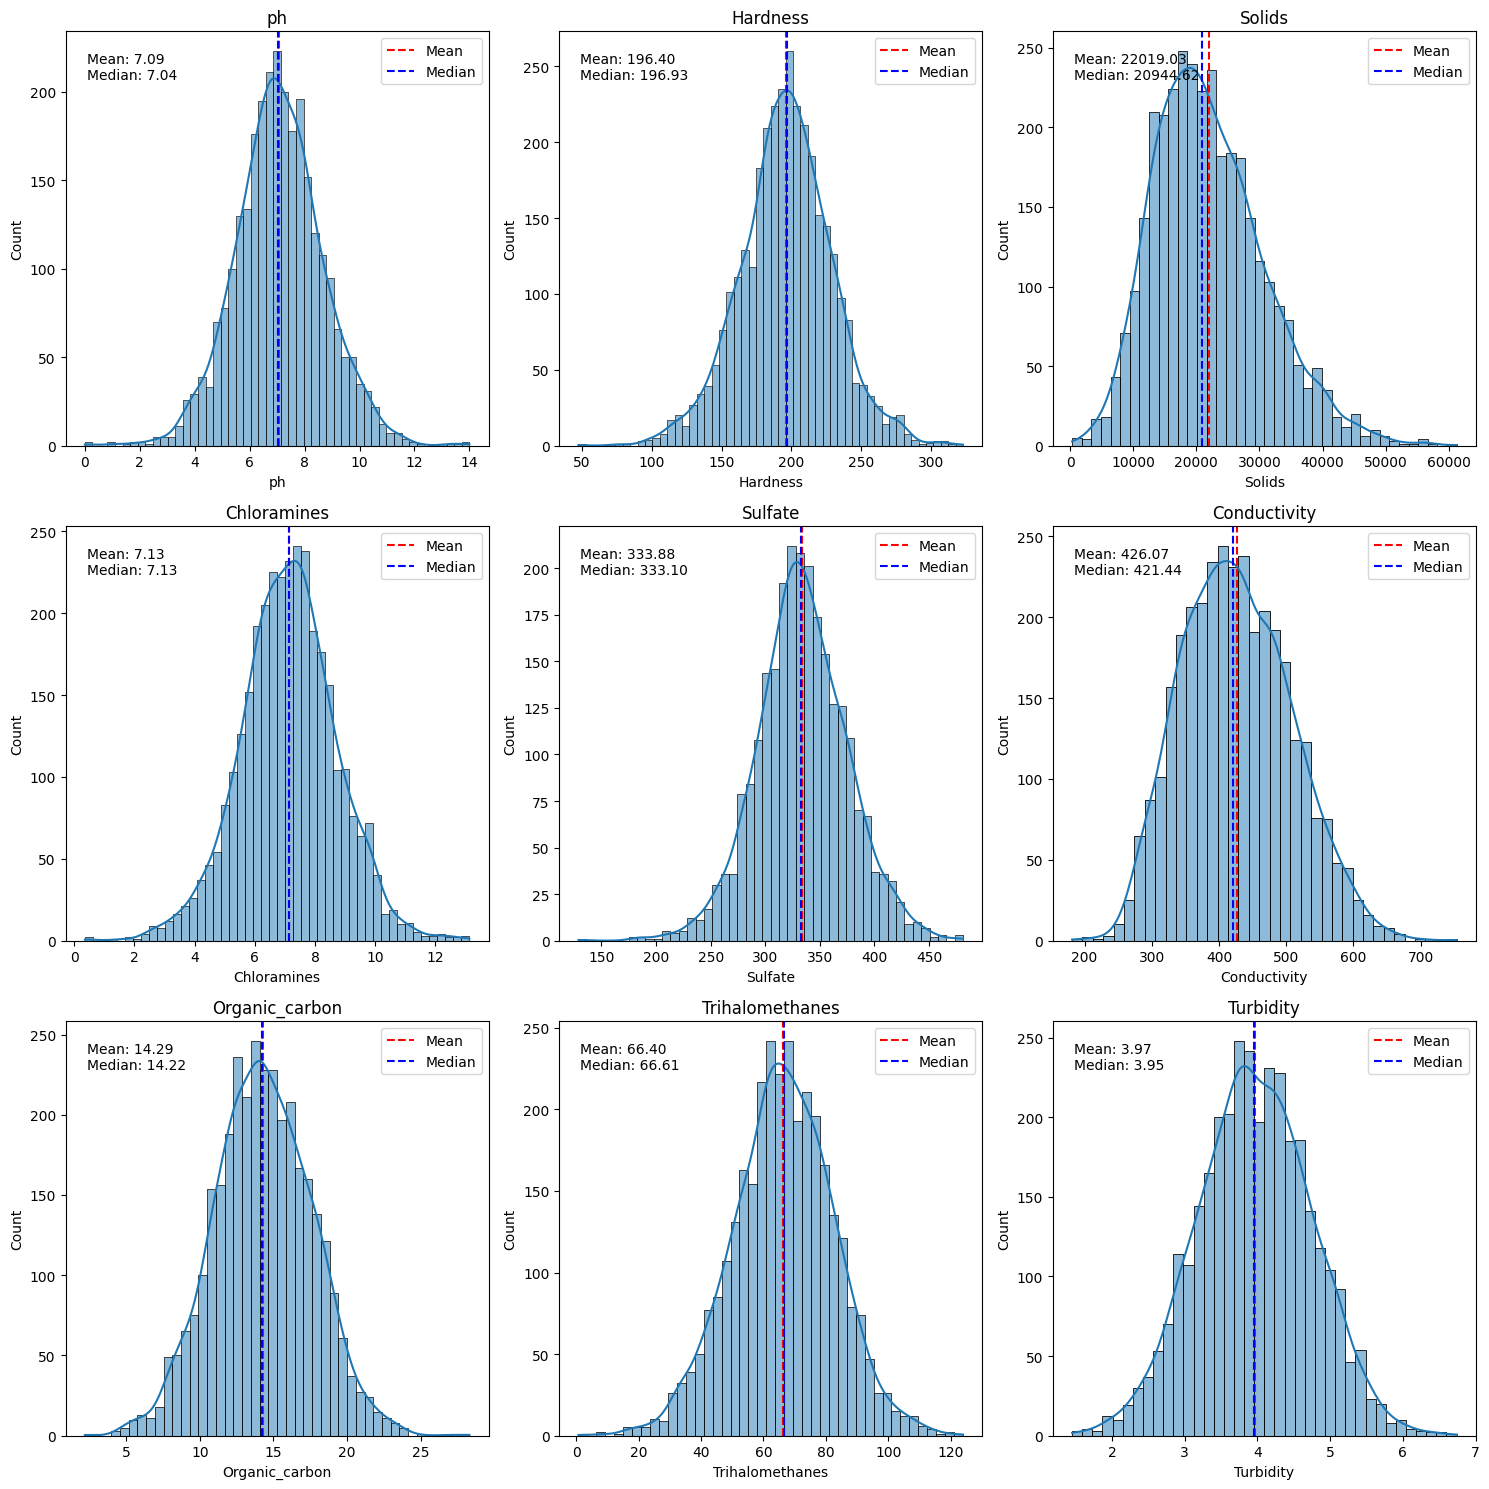

In [24]:
variables = df.columns

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

axes = axes.flatten()

for i, var in enumerate(variables):
  if(var != 'Potability'):
    ax = axes[i]
    sns.histplot(df[var], kde=True, ax=ax)
    ax.axvline(df[var].mean(), color='red', linestyle='--', label='Mean')
    ax.axvline(df[var].median(), color='blue', linestyle='--', label='Median')
    ax.annotate(f'Mean: {df[var].mean():.2f}\nMedian: {df[var].median():.2f}',
                xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')

    ax.set_title(var)
    ax.set_xlabel(var)
    ax.legend() 

plt.tight_layout()
plt.show()

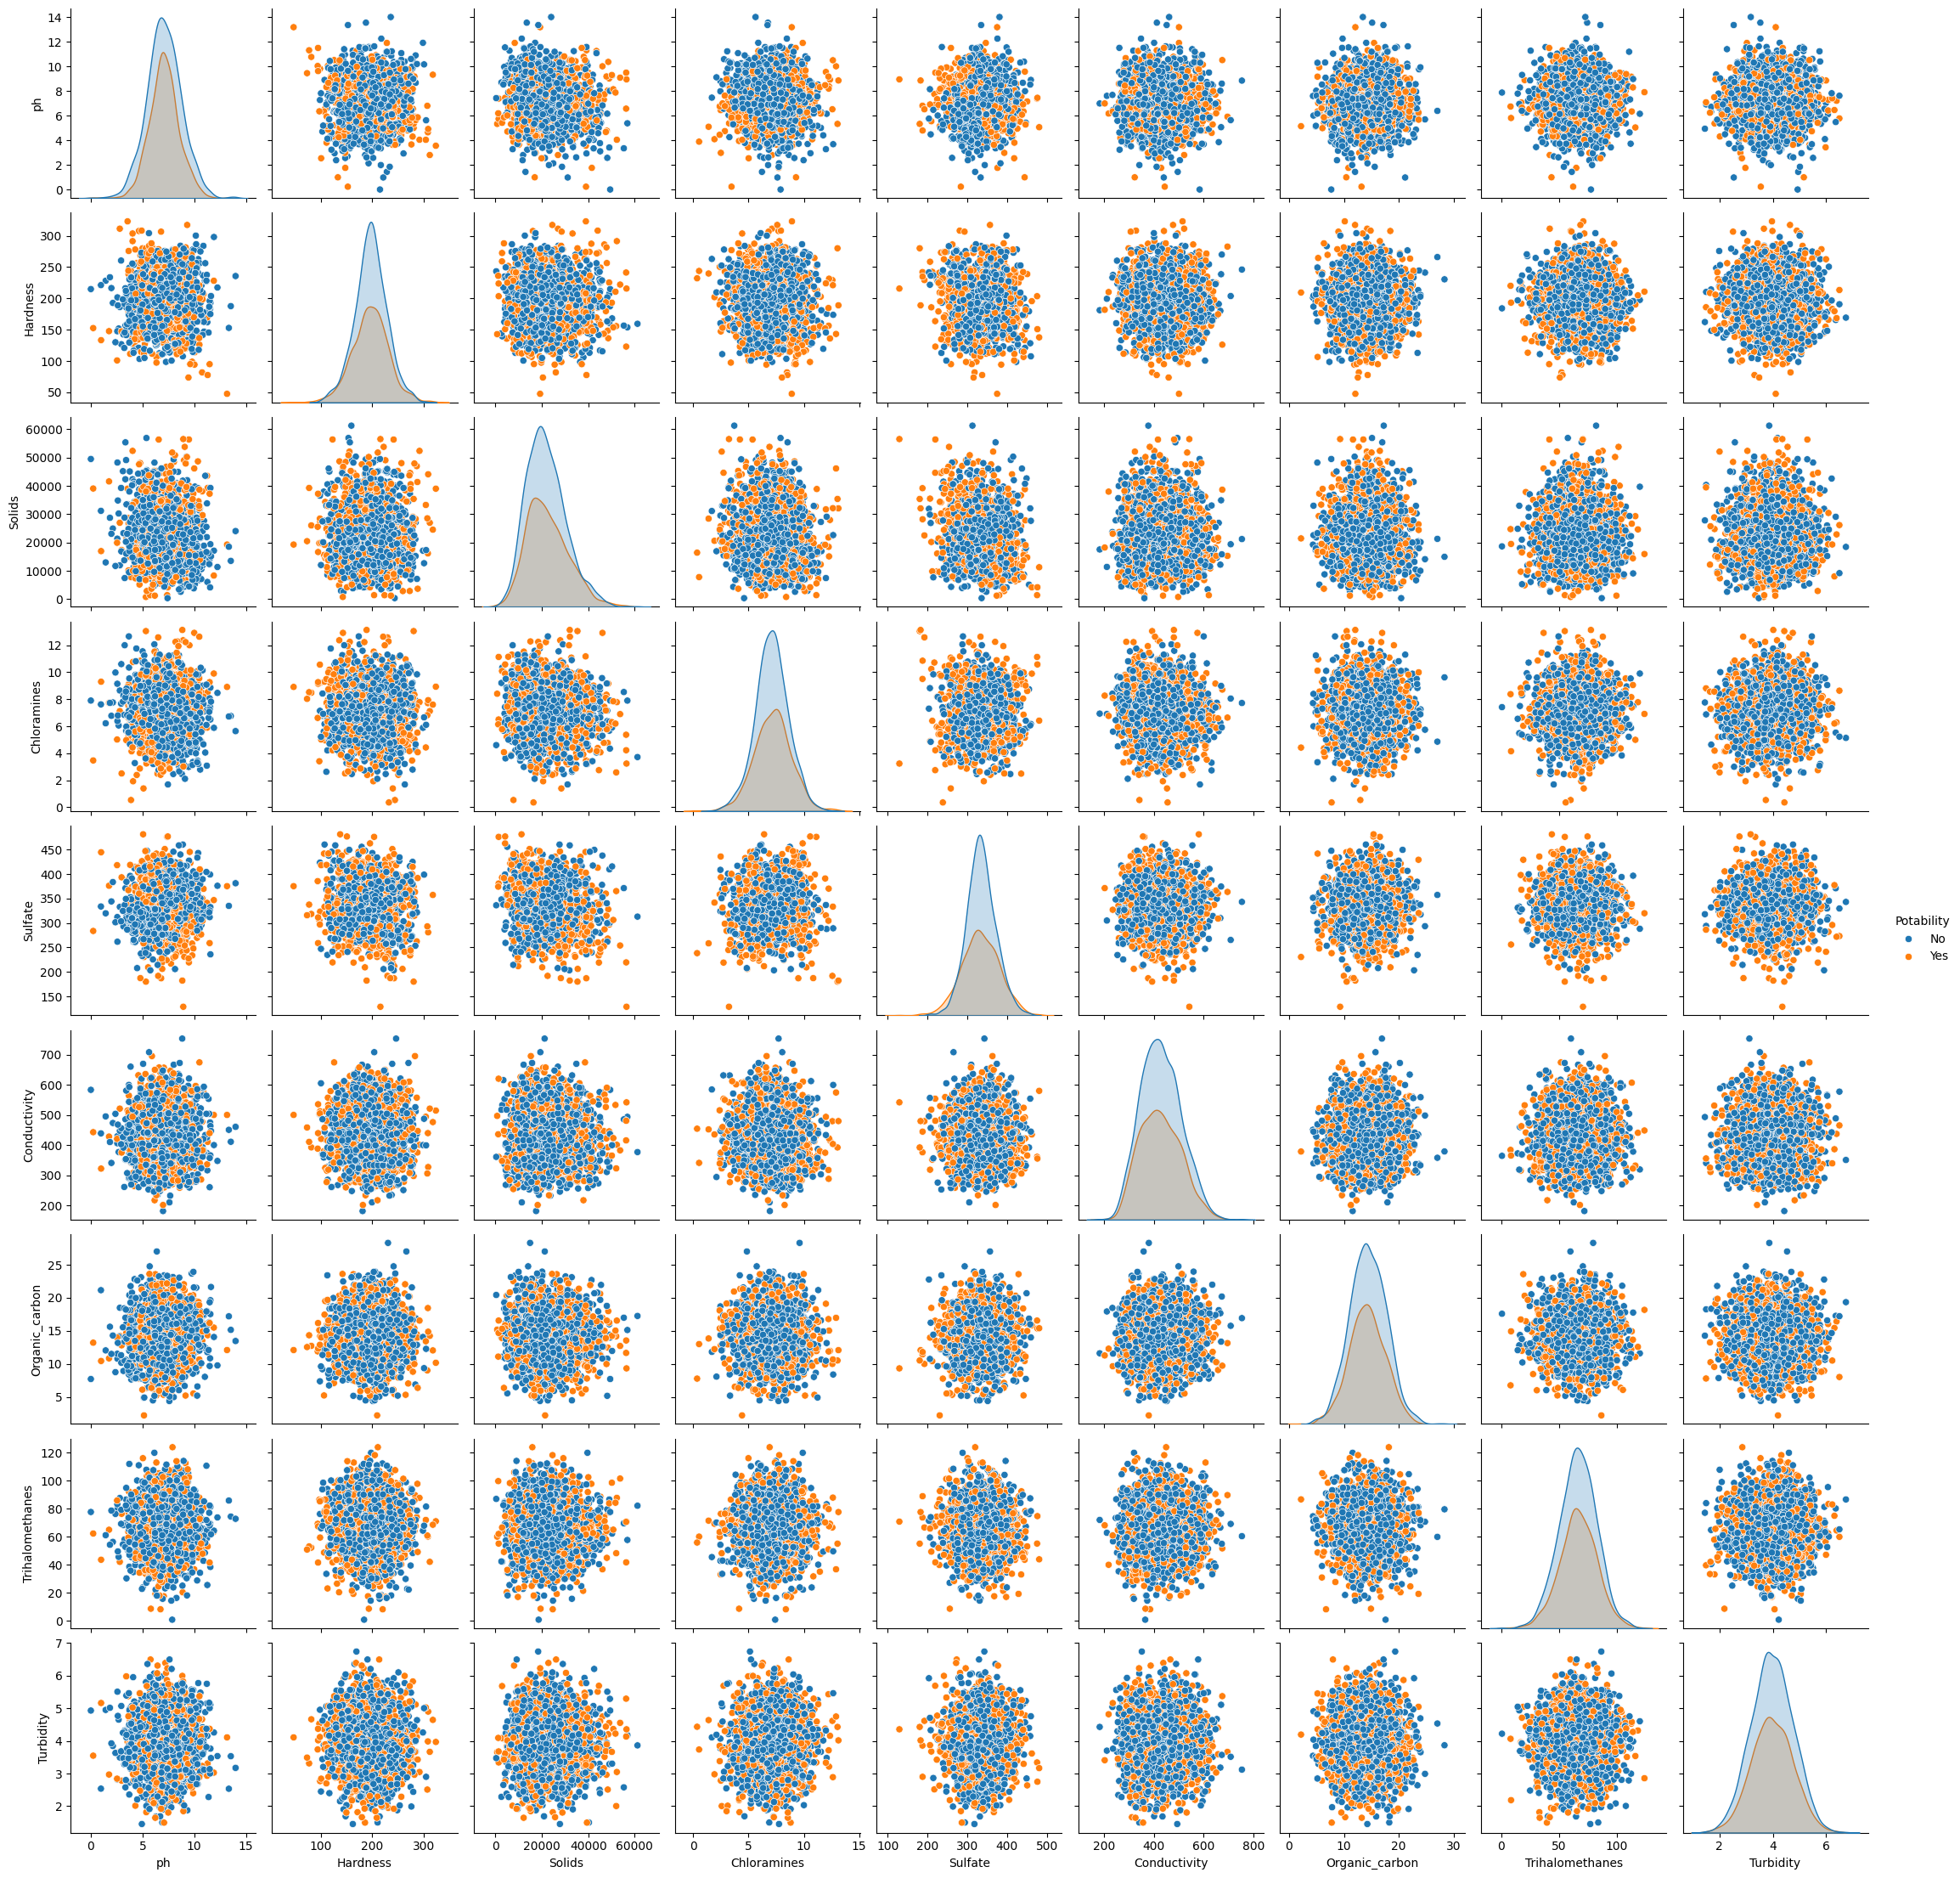

In [25]:
sns.pairplot(df, hue='Potability')
plt.show()

### the data seems to be random with no clear patterns

In [ ]:
df['Potability'] = df['Potability'].map(lambda x: 1 if x == 'Yes' else 0)

In [27]:
x_columns = df.columns[:-1]
y_column = df.columns[-1]

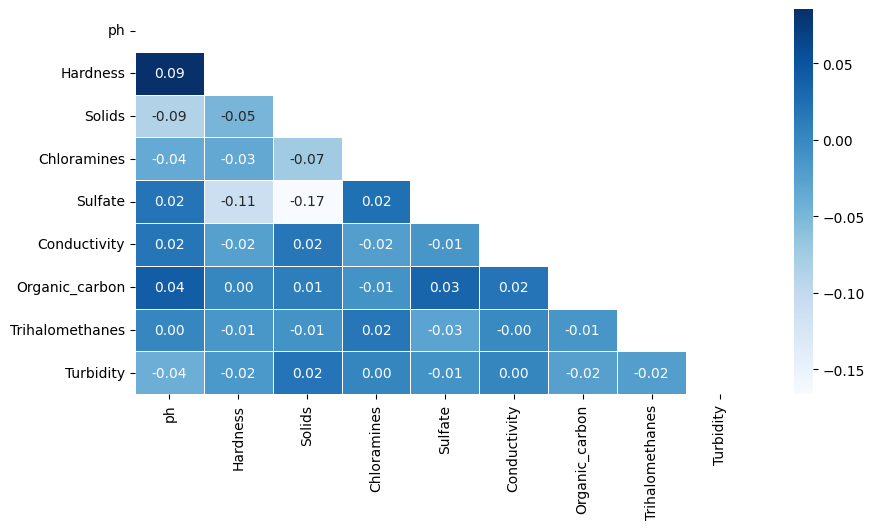

In [28]:
corr = df[x_columns].corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr, annot=True, fmt='.2f', linewidths=0.5, linecolor='white', mask=np.triu(corr), cmap='Blues')
plt.show()

### no direct relations appears

In [29]:
for column in df.columns[:-1]:
  group1 = df[df['Potability'] == 0][column]
  group2 = df[df['Potability'] == 1][column]
  t_statistic, p_value = stats.ttest_ind(group1, group2, nan_policy='omit')
  print(f"T-test for {column}: t-statistic = {t_statistic:.2f}, p-value = {p_value:.3f}")

T-test for ph: t-statistic = 0.19, p-value = 0.848
T-test for Hardness: t-statistic = 0.86, p-value = 0.390
T-test for Solids: t-statistic = -2.08, p-value = 0.037
T-test for Chloramines: t-statistic = -1.37, p-value = 0.171
T-test for Sulfate: t-statistic = 1.03, p-value = 0.302
T-test for Conductivity: t-statistic = 0.63, p-value = 0.530
T-test for Organic_carbon: t-statistic = 1.59, p-value = 0.111
T-test for Trihalomethanes: t-statistic = -0.57, p-value = 0.570
T-test for Turbidity: t-statistic = -0.24, p-value = 0.812


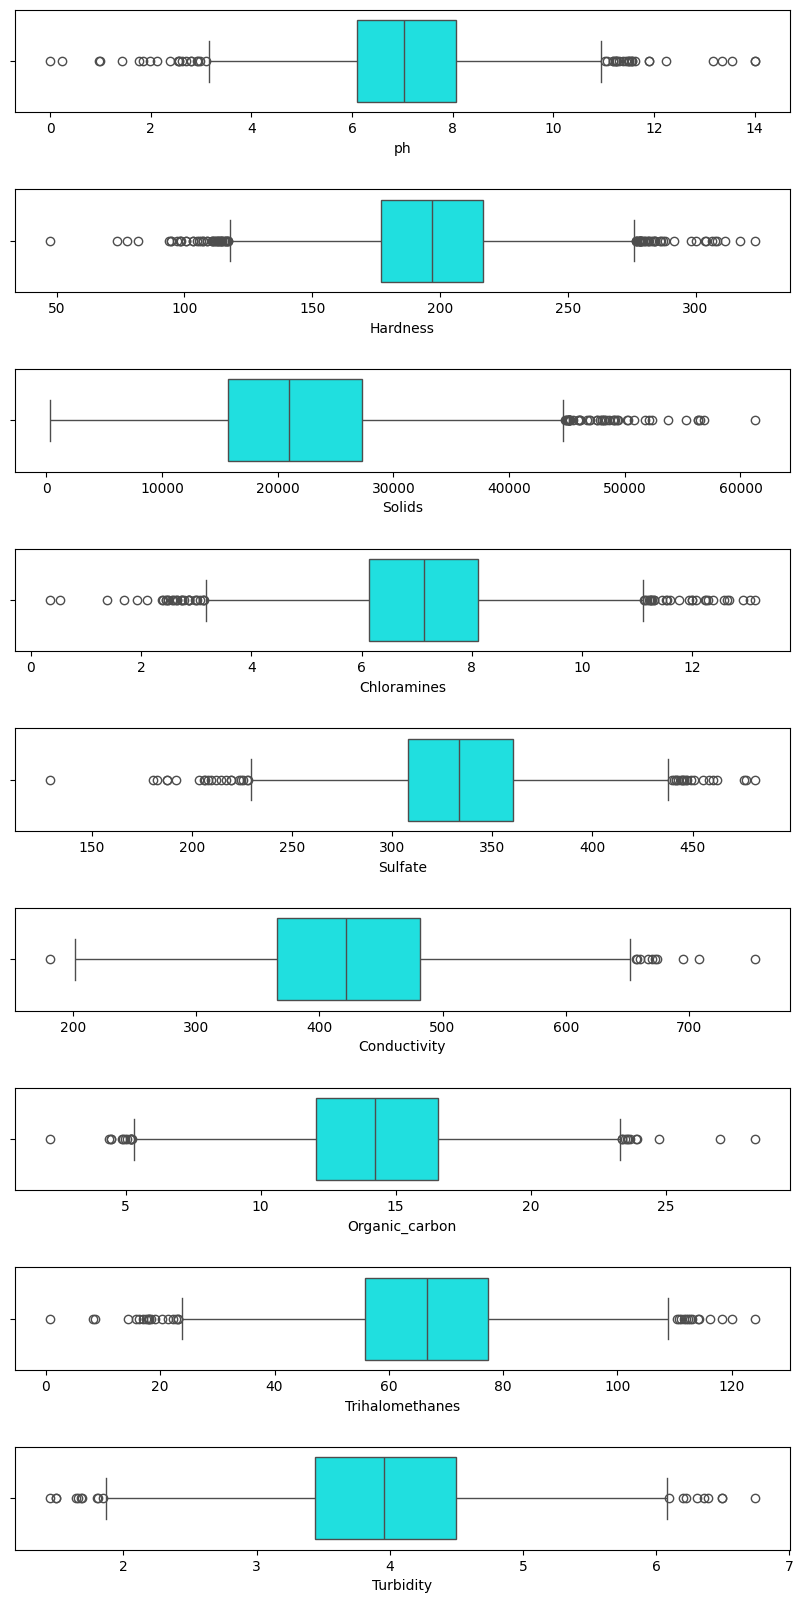

In [30]:
columns = df.columns

fig, ax = plt.subplots(9, 1, figsize=(10, 20))
fig.subplots_adjust(hspace=0.75)
for i,col in enumerate(columns) :
  if col != 'Potability' :
    sns.boxplot(x=col, data=df, ax=ax[i] , color = 'cyan')
plt.show()

### alot of outliers

## **EDA conclusion**
- All variables are normal distributed
- There is almost no correlation between numerical variables
  - using built-in function corr"it uses pearson correlation test", It's obvious that there is no correlation between any pair of variables
- No correlation between the features and target variable
  - I used t-test to test correlation between the numerical features and the categrorical target, and found that all results is bad and almost normally distributed

## column-wise analysis

1. **ph**
- pH is a measure of how acidic or basic (alkaline) a solution is on a scale of 0 to 14.
- min value for safe drinking water is 6.5 and max is 8.5

2. **Hardness**
- Water hardness refers to the concentration of calcium and magnesium salts dissolved in water. These salts are picked up as water moves through rocks and soil, where they are naturally present.

3. **solids**
- refer to the amount of inorganic and some organic minerals or salts dissolved in water, such as potassium, calcium, sodium, bicarbonates, chlorides, magnesium, and sulfates. High TDS levels can affect the taste and appearance of water, making it less desirable for use. TDS is an important factor in determining water quality
- max solids dissolved in water is 1000 mg/L

4. **Chloramines**
- chlorine and chloramine dissolved in water
- max in safe drinking water is 4 ppm

5. **Sulfate**
- sulfate dissolved in water
- max 250 mg/L

6. **Conductivity**
- Electrical conductivity (EC) actually measures the ionic process of a solution that enables it to transmit current. According to WHO standards, EC value should not exceeded 400 μS/cm

7. **Organic_carbon**
- TOC is a measure of the total amount of carbon in organic compounds in pure water. According to US EPA < 2 mg/L as TOC in treated / drinking water, and < 4 mg/Lit in source water which is use for treatment

8. **Trihalomethanes**
- THMs are chemicals which may be found in water treated with chlorine
- THM levels up to 80 ppm is considered safe in drinking water

9. **turbidity**
- The turbidity of water depends on the quantity of solid matter present in the suspended state
- max is 1 NTU

10. **Potability**:
- Indicates if water is safe for human consumption where 1 means Potable and 0 means Not potable

In [31]:
solids_limit = 1000
df[df['Solids'] > solids_limit][["Potability", "Solids"]].groupby("Potability").count()

Solids
Potability        
0             2020
1             1295

**how can 1277 row exceeds the solids limit for drinking water and marked as potable? hmm...**

In [32]:
min_ph = 6.5
max_ph = 8.5
df[((df['ph'] > max_ph) | (df['ph'] < min_ph))][["Potability", "ph"]].groupby("Potability").count()

ph
Potability     
0           952
1           526

**again, how can 518 row exceeds the ph limit for drinking water and marked as potable? let's see what about other features**

In [33]:
Chloramines_limit = 4
df[df['Chloramines'] > Chloramines_limit][["Potability", "Chloramines"]].groupby("Potability").count()

Chloramines
Potability             
0                  1967
1                  1259

In [34]:
sulfate_limit = 250
df[df['Sulfate'] > sulfate_limit][["Potability", "Sulfate"]].groupby("Potability").count()

Sulfate
Potability         
0              1506
1               960

In [35]:
carbon_limit = 2
df[df['Organic_carbon'] > carbon_limit][["Potability", "Organic_carbon"]].groupby("Potability").count()

Organic_carbon
Potability                
0                     2022
1                     1296

In [36]:
Trihalomethanes_limit = 80
df[df['Trihalomethanes'] > Trihalomethanes_limit][["Potability", "Trihalomethanes"]].groupby("Potability").count()

Trihalomethanes
Potability                 
0                       367
1                       242

In [37]:
Turbidity_limit = 1
df[df['Turbidity'] > Turbidity_limit][["Potability", "Turbidity"]].groupby("Potability").count()

Turbidity
Potability           
0                2022
1                1296

<Axes: xlabel='Solids', ylabel='Conductivity'>

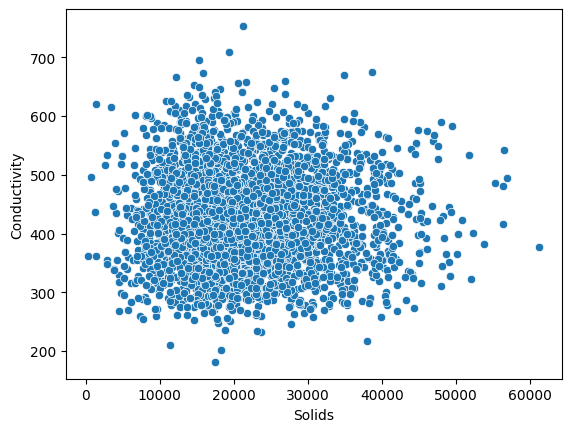

In [38]:
sns.scatterplot(x='Solids', y='Conductivity', data=df)

**we should have found a strong correlation if it's real data as conductivity depends on ions in water**

**Column-wise analysis**
- data is not real values, it's randomly generated, I got all the limits above from searching in trusted websites like world health orgnization, I assumed that there is some values measured wrong but acctually, almost all the values exceeds the limits

- There is no direct correlations or any visible patterns

In [39]:
if not hasattr(np, 'int'):
    np.int = int

from skopt import BayesSearchCV

features = df.drop(columns=['Potability'])
true_labels = df['Potability'].values

features_imputed = SimpleImputer(strategy='mean').fit_transform(features)

quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
X_scaled = quantile_transformer.fit_transform(features_imputed)

search_space = {
    'init': ['k-means++', 'random'],
    'n_init': (5, 20),
    'max_iter': (100, 500)
}

opt = BayesSearchCV(
    estimator=KMeans(n_clusters=2, random_state=42),
    search_spaces=search_space,
    scoring=make_scorer(adjusted_rand_score),
    n_iter=20,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
    verbose=0
)

opt.fit(X_scaled, true_labels)

best_kmeans = opt.best_estimator_
cluster_labels = best_kmeans.fit_predict(X_scaled)

accuracy = max(
    accuracy_score(true_labels, cluster_labels),
    accuracy_score(true_labels, 1 - cluster_labels)
)

print("Best Accuracy:", accuracy)
print("Best ARI:", opt.best_score_)
print("Best Parameters:", opt.best_params_)

Best Accuracy: 0.5150693188667872
Best ARI: 0.0010619747670810467
Best Parameters: OrderedDict({'init': 'random', 'max_iter': 102, 'n_init': 8})


In [40]:
def dbscan_ari_scorer(estimator, X, y):
    try:
        estimator.fit(X)
        labels = estimator.labels_

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters <= 1 or -1 in labels:
            return -1.0

        return adjusted_rand_score(y, labels)

    except Exception as e:
        print(f"Error during DBSCAN fitting: {e}")
        return -1.0 

search_space = {
    'eps': (0.1, 2.0, 'uniform'), 
    'min_samples': (2, 20) 
}


opt = BayesSearchCV(
    estimator=DBSCAN(),
    search_spaces=search_space,
    scoring=dbscan_ari_scorer,
    n_iter=30,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
)

opt.fit(X_scaled, true_labels)

print("\nBest DBSCAN ARI (from Bayes Search):", opt.best_score_)
print("Best DBSCAN Parameters (from Bayes Search):", opt.best_params_)


best_dbscan_model = DBSCAN(**opt.best_params_)
best_dbscan_model.fit(X_scaled)
best_cluster_labels = best_dbscan_model.labels_

if len(set(best_cluster_labels)) > 1 and -1 not in set(best_cluster_labels):
    accuracy = max(
        accuracy_score(true_labels, best_cluster_labels),
        accuracy_score(true_labels, 1 - best_cluster_labels)
    )
    print("Accuracy of the best DBSCAN model:", accuracy)
else:
     print("Best DBSCAN model did not yield suitable clusters for accuracy calculation.")


Best DBSCAN ARI (from Bayes Search): -1.0
Best DBSCAN Parameters (from Bayes Search): OrderedDict({'eps': 0.8791975218212963, 'min_samples': 15})
Best DBSCAN model did not yield suitable clusters for accuracy calculation.


### **Clustring conclusion**

Even the ML clustring algorithms were not able to recognise any patterns in the data, which suggests that there is no direct/indirect correlations between the features and the target

# data preprocessing


**filling null values**

In [41]:
df['Sulfate'].fillna(df['Sulfate'].mean(), inplace=True)
df['ph'].fillna(df['ph'].mean(), inplace=True)
df['Trihalomethanes'].fillna(df['Trihalomethanes'].mean(), inplace=True)
df['Solids'].fillna(df['Solids'].mean(), inplace=True)


after trying to handle outliers, I found that the best solution is to keep it, it can be logically true that outliers indicates water that is very polluted but actually there is outliers with potability 1, again I cannot give a reason.

we also tried to transform it with quantile transformation but we got less accuracy, and we tried to remove outliers and it's the same, the best model was without any transformation, and withoud handling the outliesrs.

In [42]:
X = df.drop('Potability', axis=1)
y = df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

training_df = pd.concat([X_train, y_train], axis=1)


df_majority = training_df[training_df.Potability==0]
df_minority = training_df[training_df.Potability==1]

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=8)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

X_train_up = df_upsampled.drop('Potability', axis=1)
y_train_up = df_upsampled['Potability']

In [43]:
y_train_up.value_counts()

Potability
0    1630
1    1630
Name: count, dtype: int64

# model training

 ### Logistic Regression

In [45]:
log_reg = LogisticRegression(max_iter=500)

param_space = {
    'C': Real(1e-6, 100.0, prior='log-uniform'),
    'penalty': Categorical(['l1', 'l2']),
    'solver': Categorical(['liblinear', 'saga']),
    'max_iter': Integer(200, 5000)
}

lr_opt = BayesSearchCV(
    estimator=log_reg,
    search_spaces=param_space,
    n_iter=30,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

transformer = QuantileTransformer()
X_transformerd = transformer.fit_transform(X_train_up)

lr_opt.fit(X_transformerd, y_train_up)
# classification report
y_pred = lr_opt.predict(transformer.transform(X_test))
report = classification_report(y_test, y_pred)
print(f"Classification report:\n{report}\n")


cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}\n")

print(f"Best hyperparameters:\n{lr_opt.best_params_} \n")

Classification report:
              precision    recall  f1-score   support

           0       0.60      0.53      0.57       392
           1       0.42      0.49      0.46       272

    accuracy                           0.52       664
   macro avg       0.51      0.51      0.51       664
weighted avg       0.53      0.52      0.52       664


Confusion Matrix:
[[209 183]
 [138 134]]

Best hyperparameters:
OrderedDict({'C': 0.7451164370027008, 'max_iter': 4709, 'penalty': 'l1', 'solver': 'liblinear'}) 



<Axes: >

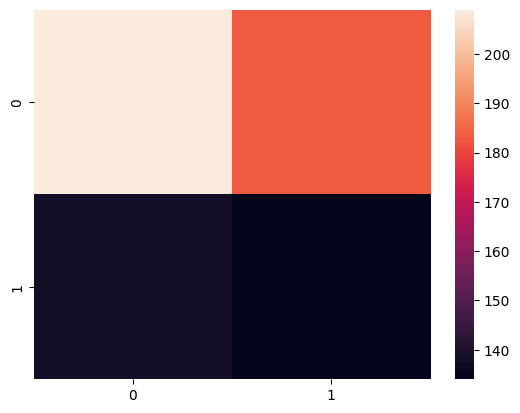

In [46]:
sns.heatmap(cm)

In [47]:
log_reg = LogisticRegression(max_iter=500)

param_space = {
    'C': Real(1e-6, 100.0, prior='log-uniform'),
    'penalty': Categorical(['l1', 'l2']),
    'solver': Categorical(['liblinear', 'saga']),
    'max_iter': Integer(200, 5000)
}

lr_opt2 = BayesSearchCV(
    estimator=log_reg,
    search_spaces=param_space,
    n_iter=30,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=0
)


lr_opt2.fit(X_train_up, y_train_up)
# classification report
y_pred = lr_opt2.predict(X_test)
report = classification_report(y_test, y_pred)
print(f"Classification report:\n{report}\n")


cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}\n")

print(f"Best hyperparameters:\n{lr_opt2.best_params_} \n")

/home/ebrahim/.cache/pypoetry/virtualenvs/water_potability-ku39s1jb-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebrahim/.cache/pypoetry/virtualenvs/water_potability-ku39s1jb-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebrahim/.cache/pypoetry/virtualenvs/water_potability-ku39s1jb-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebrahim/.cache/pypoetry/virtualenvs/water_potability-ku39s1jb-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ebrahim/.cache/pypoetry/virtualenvs/wa

Classification report:
              precision    recall  f1-score   support

           0       0.61      0.53      0.57       392
           1       0.43      0.50      0.46       272

    accuracy                           0.52       664
   macro avg       0.52      0.52      0.51       664
weighted avg       0.53      0.52      0.52       664


Confusion Matrix:
[[209 183]
 [136 136]]

Best hyperparameters:
OrderedDict({'C': 98.68837377944823, 'max_iter': 4359, 'penalty': 'l1', 'solver': 'liblinear'}) 



<Axes: >

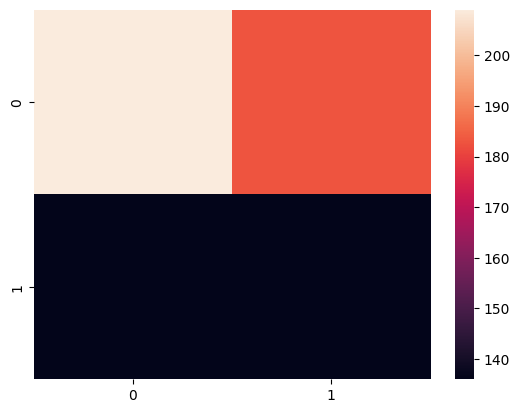

In [48]:
sns.heatmap(cm)

In [71]:
class LogisticRegressionFromScratch:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.theta = None
        self.cost_history = []

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def _add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def fit(self, X, y):
        X = self._add_intercept(X)
        y = y.ravel() 
        m, n = X.shape
        self.theta = np.zeros(n)

        for _ in range(self.num_iterations):
            z = np.dot(X, self.theta)
            h = self._sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / m 
            self.theta -= self.learning_rate * gradient

            epsilon = 1e-15
            cost = (-y * np.log(h + epsilon) - (1 - y) * np.log(1 - h + epsilon))
            self.cost_history.append(cost.mean())

    def predict_prob(self, X):
        X = self._add_intercept(X)
        return self._sigmoid(np.dot(X, self.theta))

    def predict(self, X):
        probabilities = self.predict_prob(X)
        return (probabilities > 0.5).astype(int)

In [88]:
model = LogisticRegressionFromScratch(learning_rate=0.01, num_iterations=50000)
model.fit(X_train_up, y_train_up)
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(f"Classification report:\n{report}\n")
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}\n")


Classification report:
              precision    recall  f1-score   support

           0       0.50      0.00      0.01       392
           1       0.41      1.00      0.58       272

    accuracy                           0.41       664
   macro avg       0.45      0.50      0.29       664
weighted avg       0.46      0.41      0.24       664


Confusion Matrix:
[[  1 391]
 [  1 271]]



### K Nearest Neighbours

In [49]:
knn = KNeighborsClassifier()

search_spaces = {
    'n_neighbors': Integer(1, 30),
    'weights': Categorical(['uniform', 'distance']),
    'p': Integer(1, 2)
}

knn_opt = BayesSearchCV(
    knn,
    search_spaces,
    n_iter=30,          
    cv=5,               
    scoring='accuracy', 
    random_state=42,
    n_jobs=-1
)

knn_opt.fit(X_train_up, y_train_up)

y_pred = knn_opt.predict(X_test)
report = classification_report(y_test, y_pred)
print(f"Classification report:\n{report}\n")


cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}\n")

print(f"Best hyperparameters:\n{knn_opt.best_params_} \n")

Classification report:
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       392
           1       0.45      0.33      0.38       272

    accuracy                           0.56       664
   macro avg       0.53      0.53      0.52       664
weighted avg       0.54      0.56      0.55       664


Confusion Matrix:
[[282 110]
 [182  90]]

Best hyperparameters:
OrderedDict({'n_neighbors': 1, 'p': 1, 'weights': 'distance'}) 



<Axes: >

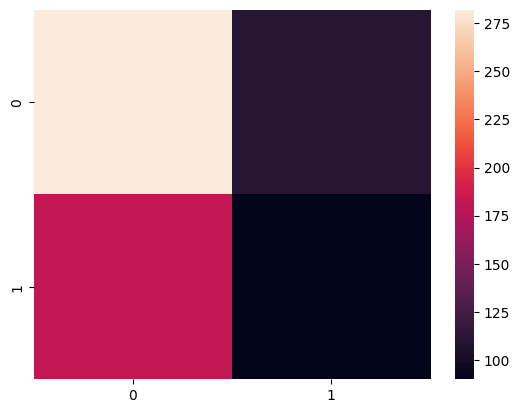

In [50]:
sns.heatmap(cm)

### Decision Tree

Accuracy: 0.58
Best hyperparameters: OrderedDict({'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 3})


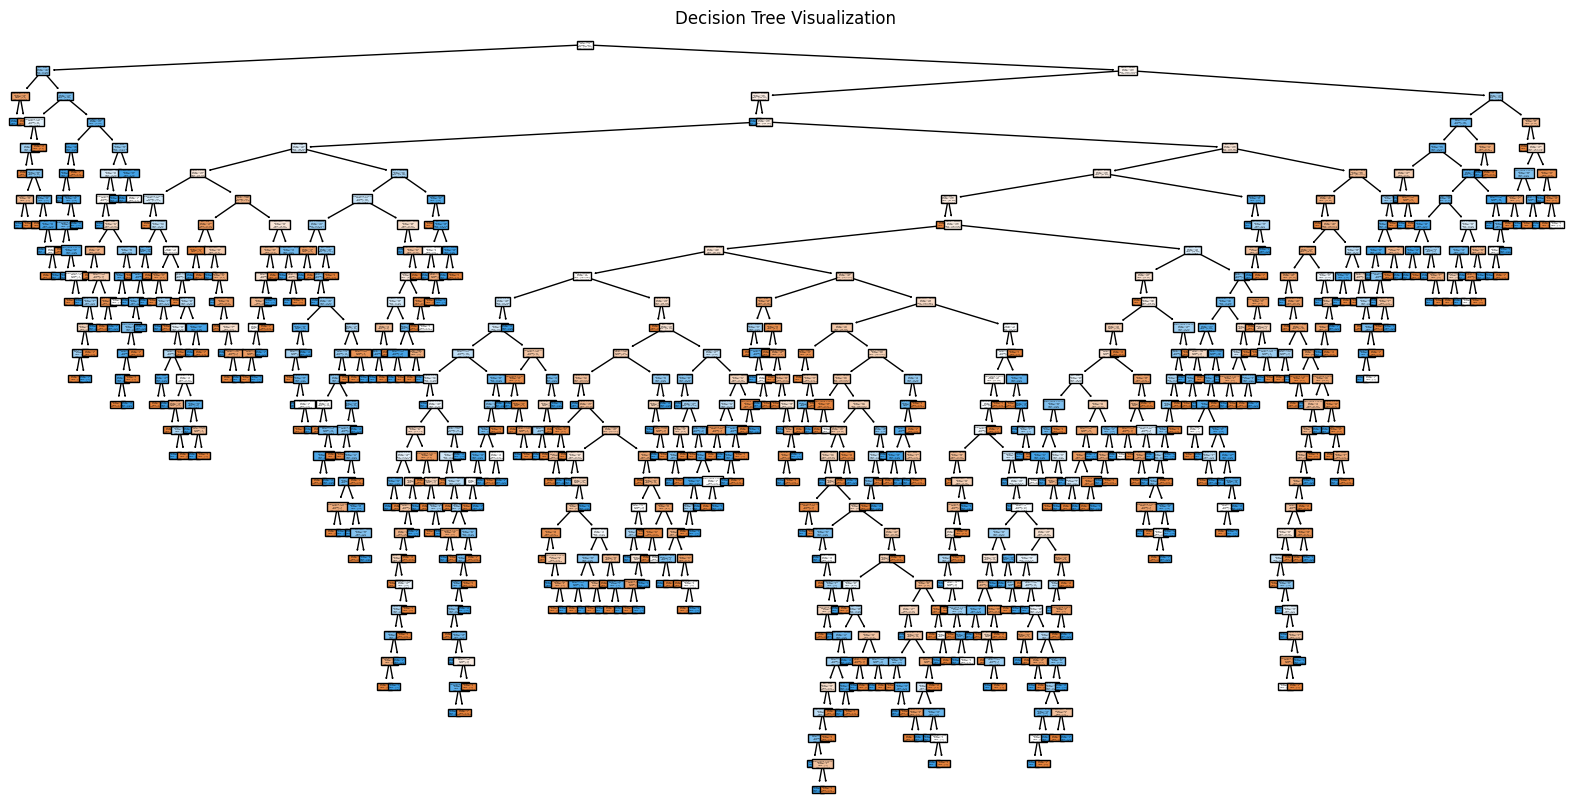

In [51]:
model = DecisionTreeClassifier(criterion='entropy', random_state=42)
search_space = {
    'max_depth': Integer(1, 30),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
}

dt_opt = BayesSearchCV(
    model,
    search_space,
    n_iter=50,
    cv=5,
    random_state=42
)
dt_opt.fit(X_train_up, y_train_up)

best_model = dt_opt.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Best hyperparameters:", dt_opt.best_params_)


# Draw the tree

plt.figure(figsize=(20, 10))
plot_tree(best_model, filled=True, feature_names=X_train_up.columns, class_names=["Not Potable", "Potable"])
plt.title("Decision Tree Visualization")
plt.show()

In [52]:
#model evaluation
y_pred = dt_opt.predict(X_test)
report = classification_report(y_test, y_pred)
print(f"Classification report:\n{report}\n")


cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}\n")

print(f"Best hyperparameters:\n{dt_opt.best_params_} \n")

Classification report:
              precision    recall  f1-score   support

           0       0.63      0.71      0.67       392
           1       0.49      0.40      0.44       272

    accuracy                           0.58       664
   macro avg       0.56      0.55      0.55       664
weighted avg       0.57      0.58      0.57       664


Confusion Matrix:
[[278 114]
 [163 109]]

Best hyperparameters:
OrderedDict({'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 3}) 



<Axes: >

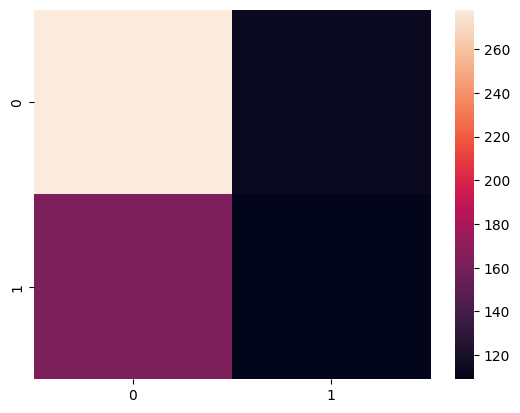

In [53]:
sns.heatmap(cm)

### Support Vector Machine

In [54]:
svm_model = SVC(random_state=42)

svm_model.fit(X_train_up, y_train_up)

y_pred = svm_model.predict(X_test)

report = classification_report(y_test, y_pred)
print(f"Classification report:\n{report}\n")


cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}\n")


Classification report:
              precision    recall  f1-score   support

           0       0.59      0.74      0.66       392
           1       0.40      0.24      0.30       272

    accuracy                           0.54       664
   macro avg       0.49      0.49      0.48       664
weighted avg       0.51      0.54      0.51       664


Confusion Matrix:
[[292 100]
 [206  66]]



<Axes: >

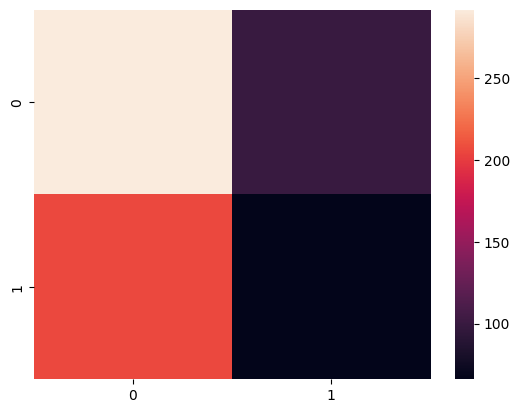

In [55]:
sns.heatmap(cm)

### XGBoost

In [56]:
xgb_model = xgboost()

# bayes search
xgb_opt = BayesSearchCV(
    xgb_model,
    {
        'n_estimators': Integer(100, 1000),
        'max_depth': Integer(3, 10),
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'subsample': Real(0.5, 1.0, 'uniform'),
        'min_child_weight': Integer(1, 10),
        'colsample_bytree': Real(0.1, 1.0, 'uniform'),
        'gamma': Real(0.1, 5.0, 'uniform'),
    },
    n_iter=32,
    verbose = 3,
    n_jobs = -1,
    cv=5
)
xgb_opt.fit(X_train_up, y_train_up)
# classification report
y_pred = xgb_opt.predict(X_test)
report = classification_report(y_test, y_pred)
print(f"Classification report:\n{report}\n")


cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}\n")

print(f"Best hyperparameters:\n{xgb_opt.best_params_} \n")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END colsample_bytree=0.32238951384869796, gamma=4.817978755458419, learning_rate=0.0662340012708227, max_depth=9, min_child_weight=4, n_estimators=610, subsample=0.7178074158132698;, score=0.613 total time=   0.5s
[CV 1/5] END colsample_bytree=0.32238951384869796, gamma=4.817978755458419, learning_rate=0.0662340012708227, max_depth=9, min_child_weight=4, n_estimators=610, subsample=0.7178074158132698;, score=0.661 total time=   0.7s
[CV 4/5] END colsample_bytree=0.32238951384869796, gamma=4.817978755458419, learning_rate=0.0662340012708227, max_depth=9, min_child_weight=4, n_estimators=610, subsample=0.7178074158132698;, score=0.641 total time=   0.6s
[CV 2/5] END colsample_bytree=0.32238951384869796, gamma=4.817978755458419, learning_rate=0.0662340012708227, max_depth=9, min_child_weight=4, n_estimators=610, subsample=0.7178074158132698;, score=0.655 total time=   0.7s
[CV 3/5] END colsample_bytree=0.32238951384869796

### Random Forest

<Axes: >

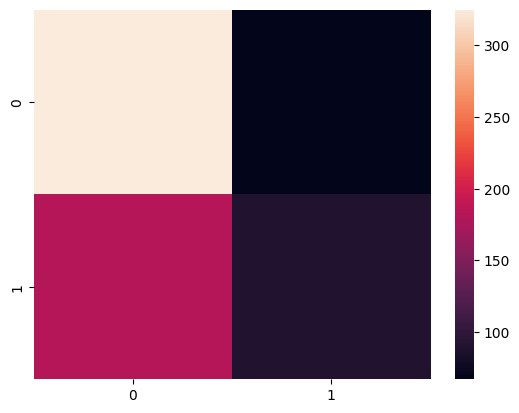

In [57]:
sns.heatmap(cm)

In [58]:
model = RandomForestClassifier(random_state=17)

search_space = {
    'n_estimators': Integer(10, 200),
    'max_depth': Integer(1, 30),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'criterion': Categorical(['gini', 'entropy', 'log_loss'])
}

rf_opt = BayesSearchCV(
    model,
    search_space,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rf_opt.fit(X_train_up, y_train_up)

best_model = rf_opt.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred)

print(f"Classification report:\n{report}\n")


cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}\n")

print(f"Best hyperparameters:\n{rf_opt.best_params_} \n")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END criterion=entropy, max_depth=22, min_samples_leaf=5, min_samples_split=5, n_estimators=137; total time=   3.7s
[CV] END criterion=entropy, max_depth=22, min_samples_leaf=5, min_samples_split=5, n_estimators=137; total time=   3.7s
[CV] END criterion=entropy, max_depth=22, min_samples_leaf=5, min_samples_split=5, n_estimators=137; total time=   3.7s
[CV] END criterion=entropy, max_depth=22, min_samples_leaf=5, min_samples_split=5, n_estimators=137; total time=   3.7s
[CV] END criterion=entropy, max_depth=22, min_samples_leaf=5, min_samples_split=5, n_estimators=137; total time=   4.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END criterion=log_loss, max_depth=27, min_samples_leaf=2, min_samples_split=10, n_estimators=174; total time=   4.6s
[CV] END criterion=log_loss, max_depth=27, min_samples_leaf=2, min_samples_split=10, n_estimators=174; total time=   4.8s
[CV] END criterion=log_loss, max_depth

<Axes: >

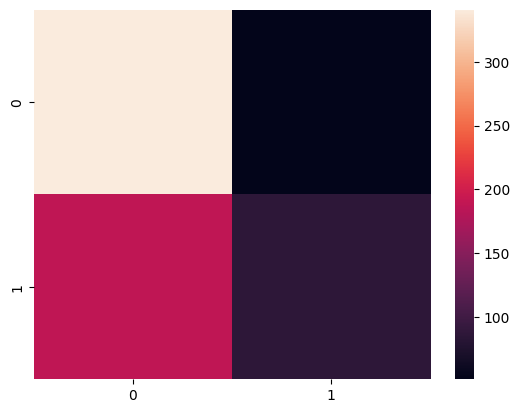

In [59]:
sns.heatmap(cm)

In [60]:
joblib.dump(rf_opt.best_estimator_, 'models/rf.joblib')
joblib.dump(lr_opt.best_estimator_, 'models/lr.joblib')
joblib.dump(knn_opt.best_estimator_, 'models/knn.joblib')
joblib.dump(xgb_opt.best_estimator_, 'models/xgb.joblib')
joblib.dump(dt_opt.best_estimator_, 'models/dt.joblib')


['models/dt.joblib']

# model evaluation

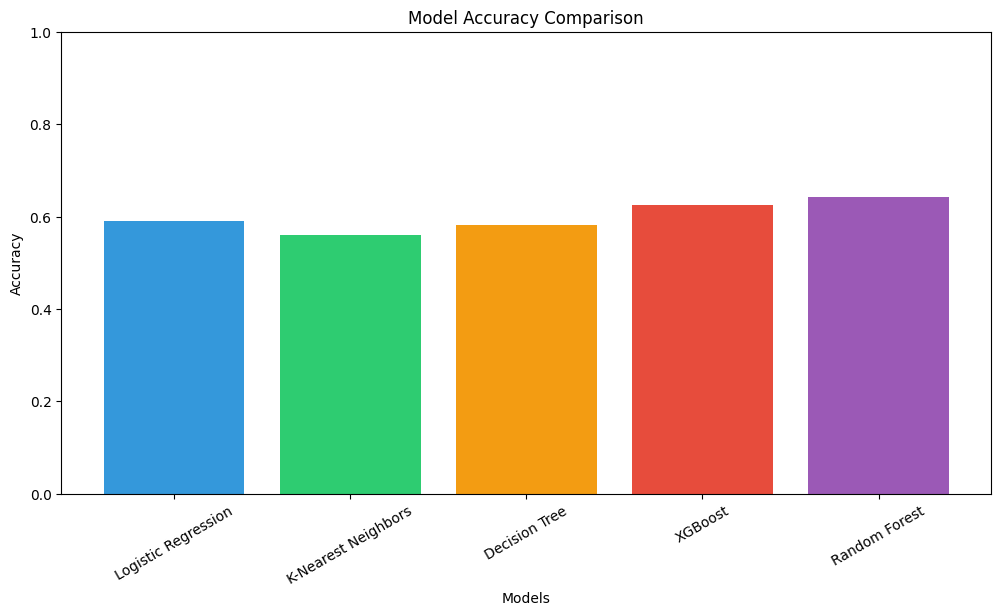

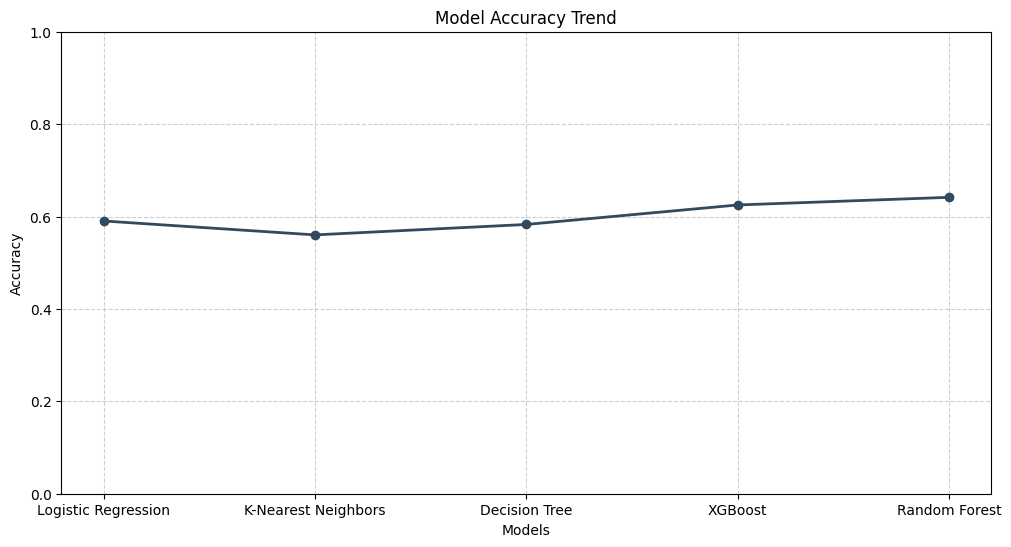

In [61]:
lr_pred = lr_opt.predict(X_test)
knn_pred = knn_opt.predict(X_test)
dt_pred = dt_opt.predict(X_test)
xgb_pred = xgb_opt.predict(X_test)
rf_pred = rf_opt.predict(X_test)

model_names = ['Logistic Regression', 'K-Nearest Neighbors', 'Decision Tree', 'XGBoost', 'Random Forest']
predictions = [lr_pred, knn_pred, dt_pred, xgb_pred, rf_pred]

accuracies = [accuracy_score(y_test, pred) for pred in predictions]

plt.figure(figsize=(12, 6))
plt.bar(model_names, accuracies, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(model_names, accuracies, marker='o', color='#34495e', linewidth=2)
plt.title('Model Accuracy Trend')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



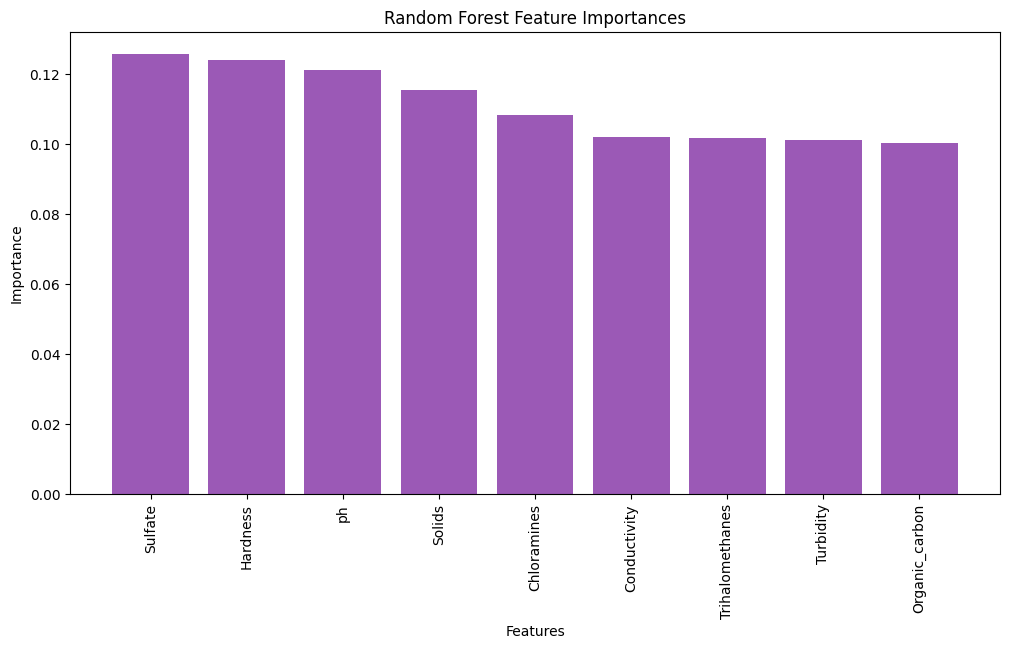

In [92]:
plt.figure(figsize=(12, 6))
importances = rf_opt.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(len(importances)), importances[indices], color='#9b59b6')
plt.xticks(range(len(importances)), np.array(X_test.columns)[indices], rotation=90)
plt.title('Random Forest Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

## feature engineering

In [97]:

X = df.drop(['Turbidity', 'Organic_carbon'], axis=1)

# Add pH Difference from Ideal
df['pH_Difference'] = abs(df['ph'] - 7.0)

# Add TDS to Hardness Ratio
df['TDS_to_Hardness_Ratio'] = df['Solids'] / df['Hardness']

X = df.drop('Potability', axis=1)


In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

training_df = pd.concat([X_train, y_train], axis=1)


df_majority = training_df[training_df.Potability==0]
df_minority = training_df[training_df.Potability==1]

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=8)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

X_train_up = df_upsampled.drop('Potability', axis=1)
y_train_up = df_upsampled['Potability']

In [99]:
model = RandomForestClassifier(random_state=17)

search_space = {
    'n_estimators': Integer(10, 200),
    'max_depth': Integer(1, 30),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'criterion': Categorical(['gini', 'entropy', 'log_loss'])
}

rf_opt = BayesSearchCV(
    model,
    search_space,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rf_opt.fit(X_train_up, y_train_up)

best_model = rf_opt.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred)

print(f"Classification report:\n{report}\n")


cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}\n")

print(f"Best hyperparameters:\n{rf_opt.best_params_} \n")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [101]:
model = RandomForestClassifier(random_state=17)

search_space = {
    'n_estimators': Integer(10, 500),
    'max_depth': Integer(1, 50),
    'min_samples_split': Integer(2, 15),
    'min_samples_leaf': Integer(1, 8),
    'criterion': Categorical(['gini', 'entropy', 'log_loss'])
}

rf_opt2 = BayesSearchCV(
    model,
    search_space,
    n_iter=80,
    cv=5,
    n_jobs=-1,
    verbose=0,
    random_state=42
)

transformer = QuantileTransformer()
X_transformerd = transformer.fit_transform(X_train_up)


rf_opt2.fit(X_transformerd, y_train_up)

best_model = rf_opt2.best_estimator_

y_pred = best_model.predict(transformer.transform(X_test))

accuracy = accuracy_score(y_test, y_pred)

report = classification_report(y_test, y_pred)

print(f"Classification report:\n{report}\n")


cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}\n")

print(f"Best hyperparameters:\n{rf_opt2.best_params_} \n")


Classification report:
              precision    recall  f1-score   support

           0       0.65      0.88      0.75       392
           1       0.64      0.31      0.42       272

    accuracy                           0.65       664
   macro avg       0.65      0.60      0.58       664
weighted avg       0.65      0.65      0.61       664


Confusion Matrix:
[[345  47]
 [187  85]]

Best hyperparameters:
OrderedDict([('criterion', 'gini'), ('max_depth', 30), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 500)]) 



# conclusion

**We couldn't actually explain the correlation in the data or interpret the model behaviour due to the randomness of the data, but randomforest was the best model that could capture hidden patterns well, with bayesian optimaization and then with stacking we got the best accuracy and feature engineering performed significant diffrence.**

**but, this model cannot go to the deployment phase in real life, because the data is not real and it will give wrong ouptuts when take a correct input.**

**thank you**
